## 0. Библиотеки и функции

In [1]:
import pandas as pd
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

import seaborn as sns
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None

In [2]:
def place_labels(ax, format_string):
    rects = ax.patches

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        # Use X value as label and format number with one decimal place
        label = format_string.format(x_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                        # positive and negative values.

## 1. Подготовка данных
### 1.1. Открываем и объединяем файлы

In [3]:
channel_dfs = []
for file in glob.glob('*.csv'):
    channel_df = pd.read_csv(file, dtype={'ts':str,'thread_ts':str})
    channel_df['channel_name'] = file.replace('.csv','')
    channel_dfs.append(channel_df)
slack_df = pd.concat(channel_dfs)

### 1.2. Объединяем каналы

In [4]:
print(slack_df['channel_name'].unique())

['archive_da_21_exerciser_1' 'archive_da_21_exerciser_2'
 'archive_da_21_projects_1' 'archive_da_21_projects_2' 'da_21_exerciser'
 'da_21_info' 'da_21_library' 'da_21_projects' 'da_21_teamwork']


Переименуем каналы, чтобы объединить сообщения из каналов одинакового назначения

In [5]:
replace_dict = {}
purposes = ['exerciser', 'projects', 'teamwork']
for purpose in purposes:
    for channel in [name for name in slack_df['channel_name'].unique() if purpose in name]:
        replace_dict[channel] = f'da_11_{purpose}'
        
slack_df['channel_name'] = slack_df['channel_name'].replace(replace_dict)

print(slack_df['channel_name'].unique())

['da_11_exerciser' 'da_11_projects' 'da_21_info' 'da_21_library'
 'da_11_teamwork']


### 1.3. Приводим типы и заполняем пропуски
- Добавим колонку `datetime`, где будет дата-время на основе unix epoch из колонки `ts`
- Пропуски в колонке `thread_ts` означают, что для треда нет внутренних сообщений (реплаев), поэтому в качестве идентификатора такого треда подойдёт значение колонки `ts`. Заполним пропуски в `thread_ts` на значение из колонки `ts`

In [6]:
slack_df['datetime'] = slack_df['ts'].astype(float).apply(datetime.fromtimestamp)
slack_df['thread_ts'] = slack_df['thread_ts'].fillna(slack_df['ts'])

slack_df['date'] = slack_df['datetime'].dt.date
slack_df['month'] = slack_df['datetime'].astype('datetime64[M]')

In [7]:
slack_df['is_thread_starter'] = slack_df['thread_ts'] == slack_df['ts']

In [8]:
slack_df['text_length'] = slack_df['text'].str.len().fillna(0).astype(int)

## 2. Исследование пользователей
Перед исследованием пользователей создадим копию датафрейма, где не будет сообщений от пользователей из команды Практикума

In [9]:
praktikum_users = ['USAAUCX18', 'UU59EH1B8', 'USWMKAJHW', 'U0104BRNQG1', 'USNLJ4U21', 'UUMQAGFHC']
slack_wo_praktikum_df = slack_df[~slack_df['user'].isin(praktikum_users)]

### 2.1. Составим рейтинг из 10 пользователей, оставивших наибольшее количество сообщений

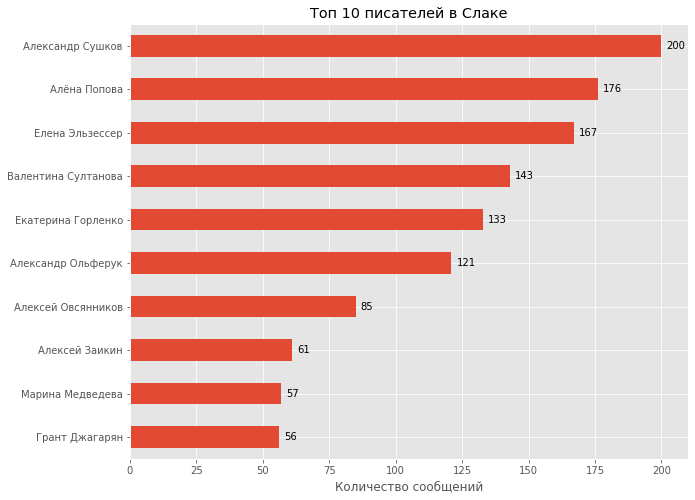

In [10]:
top_10_users = (
    slack_wo_praktikum_df['real_name']
    .value_counts()
    .nlargest(10)
)

plt.figure(figsize=(10,8)) # Сделаем больше размеры фигуры
ax = (
    top_10_users
    .sort_values()
    .plot(kind='barh')
)
plt.title('Топ 10 писателей в Слаке') # Укажем название фигуры
place_labels(ax,"{:.0f}")
plt.xlabel('Количество сообщений')
plt.show()

### 2.1. Определим куда пользователи писали чаще всего

In [11]:
messages_by_top_10_users_df = slack_wo_praktikum_df[slack_wo_praktikum_df['real_name'].isin(top_10_users.index)]

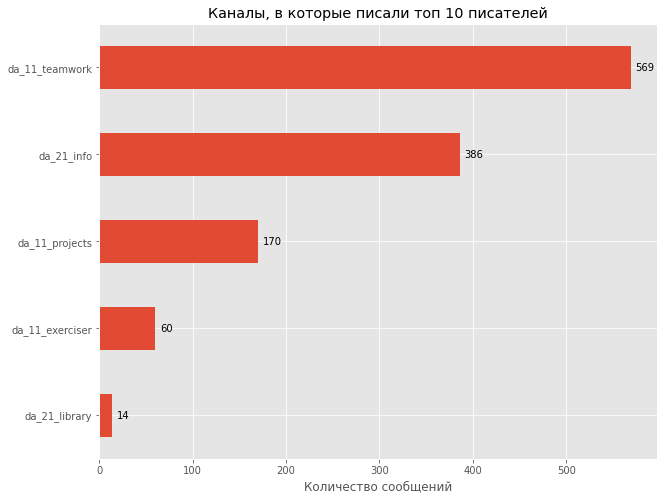

In [12]:
plt.figure(figsize=(10,8))
ax = (
    messages_by_top_10_users_df['channel_name']
    .value_counts().sort_values()
    .plot(kind='barh')
)
plt.title('Каналы, в которые писали топ 10 писателей') # Укажем название фигуры
place_labels(ax,"{:.0f}")
plt.xlabel('Количество сообщений')
plt.show()

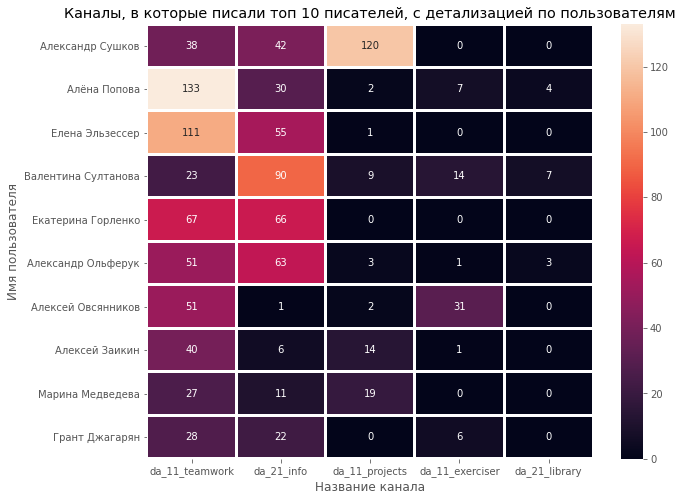

In [13]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(
    messages_by_top_10_users_df.
    pivot_table(index='real_name',
                columns='channel_name',
                values='ts',
                aggfunc='count',
                fill_value=0,
               margins=True)
    .sort_values('All',ascending=False)
    .sort_values('All',ascending=False,axis=1)
    .drop(index='All',columns='All'),
    annot = True,
    linewidths = 2,
    fmt = "d"
)
plt.title('Каналы, в которые писали топ 10 писателей, с детализацией по пользователям')
plt.xlabel('Название канала')
plt.ylabel('Имя пользователя')
plt.show()

### 2.2. Найдем пользователей, которые чаще других создавали треды

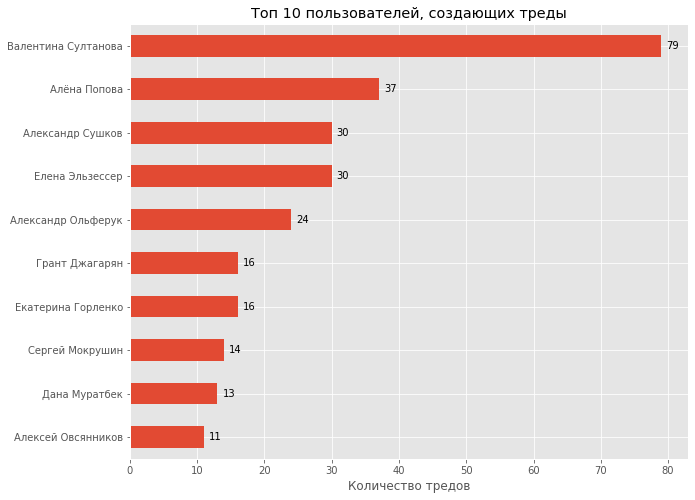

In [14]:
plt.figure(figsize=(10,8))
ax = (
    slack_wo_praktikum_df
    .sort_values('datetime')
    .query('is_thread_starter')
    .loc[:,'real_name'].value_counts()
    .nlargest(10).sort_values()
    .plot(kind='barh')
)
plt.title('Топ 10 пользователей, создающих треды') # Укажем название фигуры
place_labels(ax,"{:.0f}")
plt.xlabel('Количество тредов')
plt.show()

### 2.3. Выясним, как меняется со временем количество пользователей, которые пишут сообщения

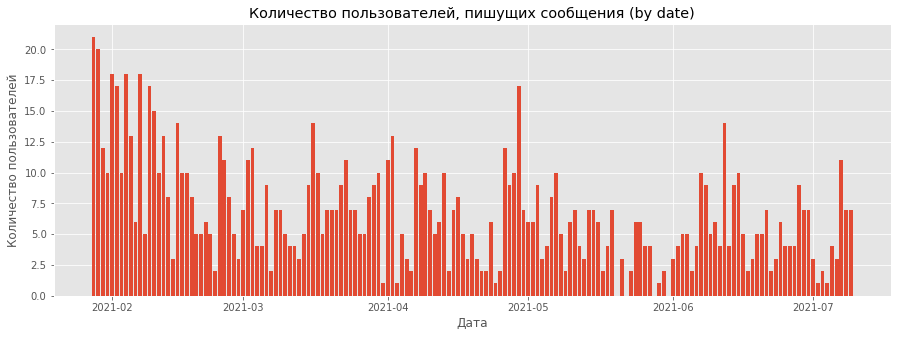

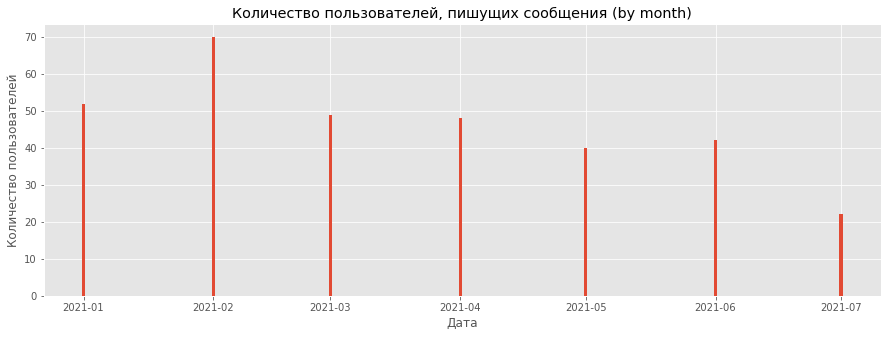

In [15]:
for grouping_column in ['date','month']:
    sub_df = slack_wo_praktikum_df.groupby(grouping_column)['user'].nunique()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.bar(sub_df.index, sub_df.values)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.title(f'Количество пользователей, пишущих сообщения (by {grouping_column})')
    plt.xlabel('Дата')
    plt.ylabel('Количество пользователей')
    plt.show()

## 3. Исследование сообщений
### 3.1.1 Определим, какие каналы содержат больше всего тредов

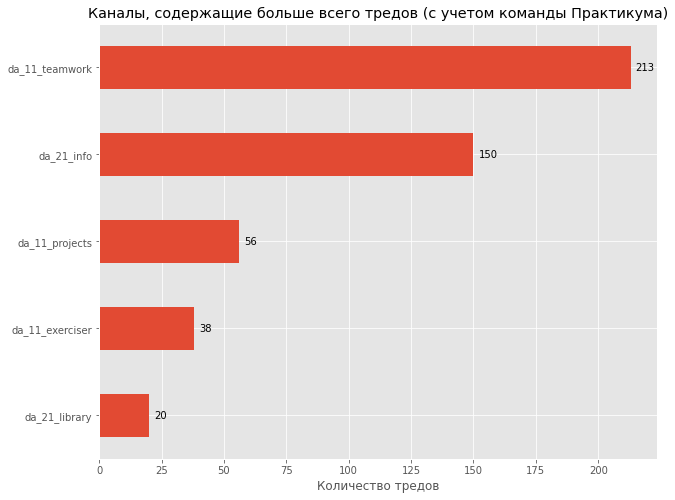

In [16]:
plt.figure(figsize=(10,8))
ax = (
    slack_df
    .query('is_thread_starter')
    .loc[:,'channel_name'].value_counts().sort_values()
    .plot(kind='barh')
)
plt.title('Каналы, содержащие больше всего тредов (с учетом команды Практикума)') # Укажем название фигуры
place_labels(ax,"{:.0f}")
plt.xlabel('Количество тредов')
plt.show()

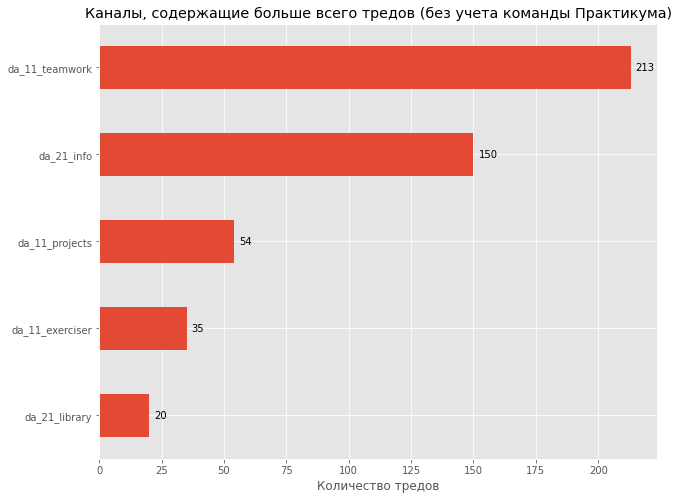

In [17]:
plt.figure(figsize=(10,8))
ax = (
    slack_wo_praktikum_df
    .query('is_thread_starter')
    .loc[:,'channel_name'].value_counts().sort_values()
    .plot(kind='barh')
)
plt.title('Каналы, содержащие больше всего тредов (без учета команды Практикума)') # Укажем название фигуры
place_labels(ax,"{:.0f}")
plt.xlabel('Количество тредов')
plt.show()

### 3.2. Построим гистограмму распределения количества сообщений в тредах для каждого из каналов

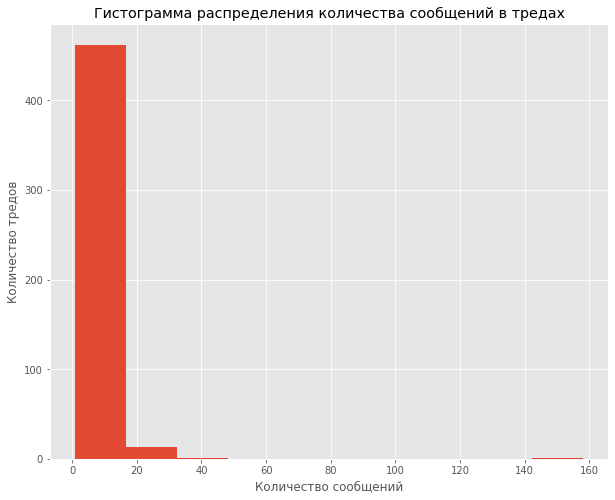

In [18]:
plt.figure(figsize=(10,8))
ax = (
    slack_df
    .groupby('thread_ts')['ts'].count()
    .hist(bins=10)
)
plt.title('Гистограмма распределения количества сообщений в тредах') # Укажем название фигуры
plt.xlabel('Количество сообщений')
plt.ylabel('Количество тредов')
plt.show()

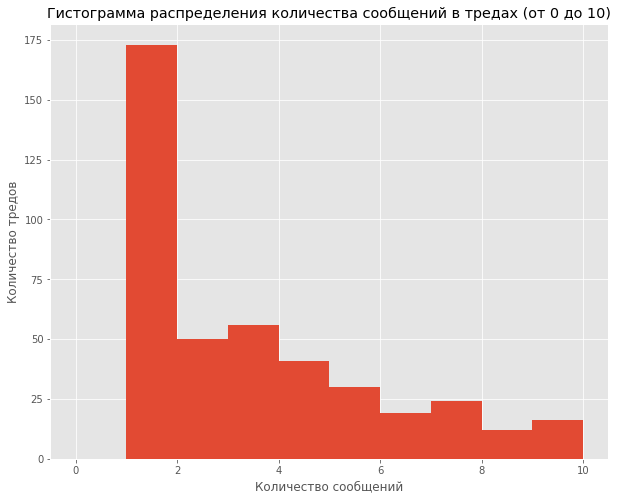

In [19]:
plt.figure(figsize=(10,8))
ax = (
    slack_df
    .groupby('thread_ts')['ts'].count()
    .hist(bins=10,range=(0,10))
)
plt.title('Гистограмма распределения количества сообщений в тредах (от 0 до 10)') # Укажем название фигуры
plt.xlabel('Количество сообщений')
plt.ylabel('Количество тредов')
plt.show()

### 3.3. Выясним, как меняется количество сообщений в тредах с течением времени

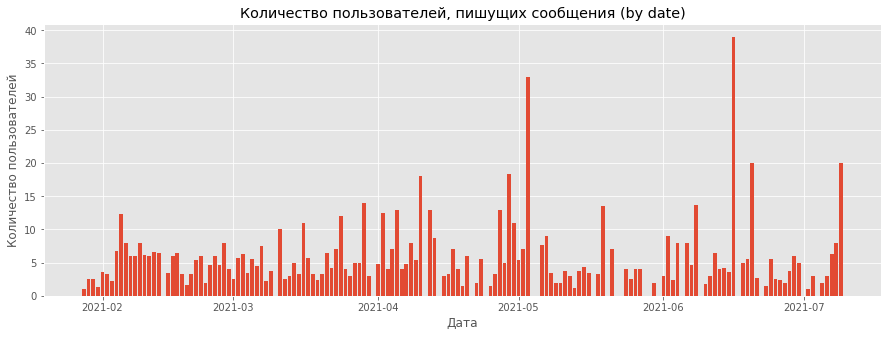

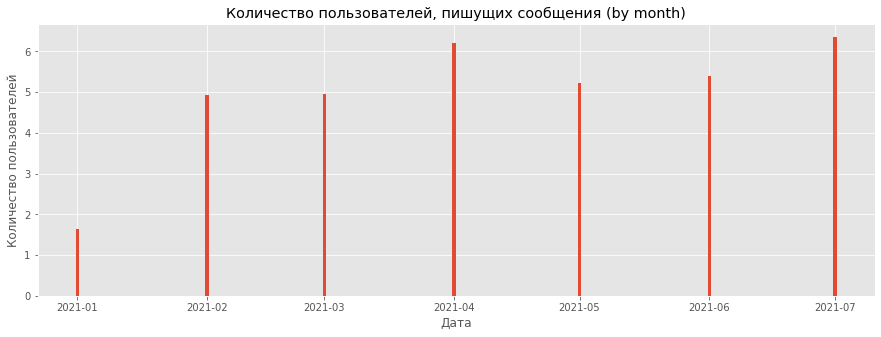

In [20]:
for grouping_column in ['date','month']:
    sub_df = (
        slack_df
        .query('is_thread_starter')
        .groupby(grouping_column).agg(threads_count=('ts','count'))
        .join(
            slack_df
            .groupby(grouping_column).agg(messages_count=('ts','count'))
        )
        .assign(messages_per_thread = lambda x: x['messages_count']/x['threads_count'])
        .loc[:,'messages_per_thread']
    )
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.bar(sub_df.index, sub_df.values)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.title(f'Количество пользователей, пишущих сообщения (by {grouping_column})')
    plt.xlabel('Дата')
    plt.ylabel('Количество пользователей')
    plt.show()

### 3.4. Найдём треды, собравшие наибольшее количество сообщений

In [21]:
largest_threads = slack_df['thread_ts'].value_counts().nlargest(10)

larges_threads_df = (
    slack_df[(slack_df['is_thread_starter']) & (slack_df['thread_ts'].isin(largest_threads.index))]
    .join(largest_threads,on='thread_ts',rsuffix='_count')
)

In [22]:
# Выведем сообщения 
for x in larges_threads_df.sort_values('thread_ts_count',ascending=False).itertuples():
    print (f'Канал: {x.channel_name}; Автор: {x.real_name}\n----')
    print (x.text)
    print ('----')
    print (f'{x.thread_ts_count} сообщений\n\n')

Канал: da_11_projects; Автор: Михаил Кузнецов
----
Анализ бизнес-показателей
----
158 сообщений


Канал: da_11_exerciser; Автор: Олеся Лозинская / Ole Lo
----
<@UU59EH1B8> Привет! работаю с <https://code.s3.yandex.net/datasets/schedules.csv|schedules.csv> в Табло. Во-первых Task Number превратился в Taks. А во-вторых почему другой тип таблицы? Он как-то меняется? Я строю диаграмму Gantt, пока выходит не та
----
42 сообщений


Канал: da_21_info; Автор: Екатерина Горленко
----
*<!channel>*
Всем привет!

Многие из вас уже закончили один из самых творческих проектов *"Как рассказать историю с помощью данных"*. Не терпится посмотреть на ваши презентации!

Давайте сделаем еще одну *ПРОЖАРКУ*:fire: во вторник, 1.06.2021 в 19-00 по мск

Это полезно и для автора работы и для коллег. Пока все находятся в контексте одной проблемы, решения становятся очень выпуклыми. В этой работе посмотрим на презентацию и ваше решение по обогащению данных (работа с внешними источниками), тут могут быть разные по

### 3.5. Проанализируем изменение средней длины сообщения в зависимости от канала

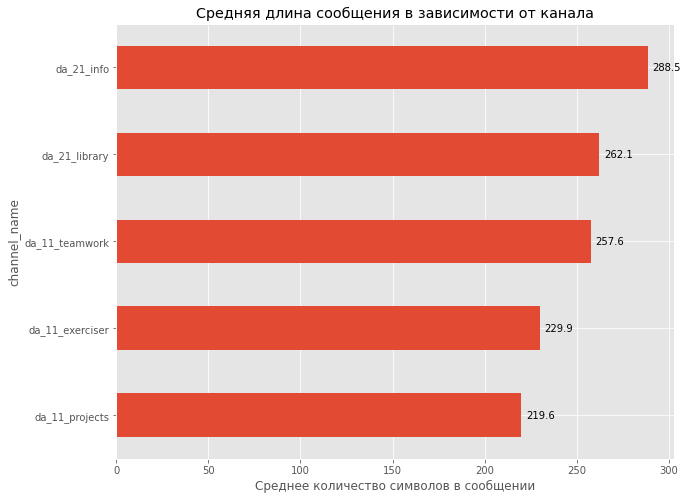

In [23]:
plt.figure(figsize=(10,8))
ax = (
    slack_df
    .groupby('channel_name')['text_length'].mean()
    .sort_values()
    .plot(kind='barh')
)
plt.title('Средняя длина сообщения в зависимости от канала') # Укажем название фигуры
place_labels(ax,"{:.1f}")
plt.xlabel('Среднее количество символов в сообщении')
plt.show()

In [24]:
slack_df['text_length_category'] = pd.qcut(slack_df['text_length'], 3, labels=["short", "normal", "long"])

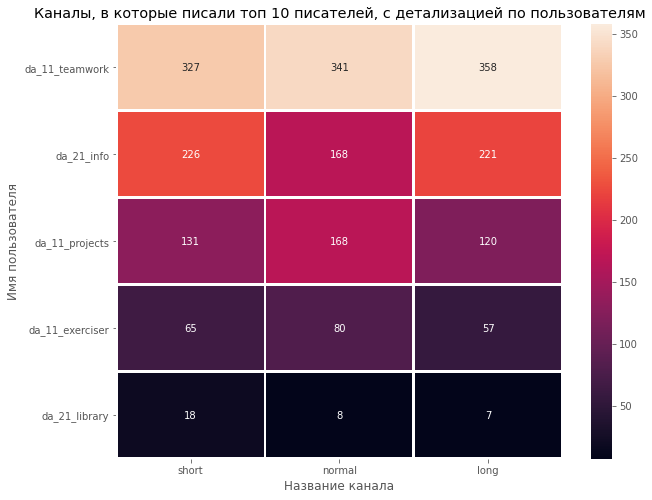

In [25]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(
    slack_df.
    pivot_table(index='channel_name',
                columns='text_length_category',
                values='ts',
                aggfunc='count',
                fill_value=0,
               margins=True)
    .sort_values('All',ascending=False)
    .filter(['short','normal','long'])
    .drop(index='All'),
    annot = True,
    linewidths = 2,
    fmt = "d"
)
plt.title('Каналы, в которые писали топ 10 писателей, с детализацией по пользователям')
plt.xlabel('Название канала')
plt.ylabel('Имя пользователя')
plt.yticks(rotation=0)
plt.show()

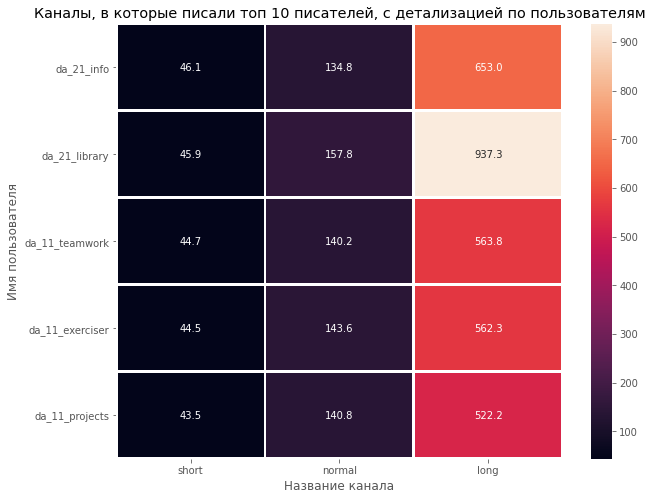

In [26]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(
    slack_df.
    pivot_table(index='channel_name',
                columns='text_length_category',
                values='text_length',
                aggfunc='mean',
                fill_value=0,
               margins=True)
    .sort_values('All',ascending=False)
    .filter(['short','normal','long'])
    .drop(index='All'),
    annot = True,
    linewidths = 2,
    fmt = ".1f"
)
plt.title('Каналы, в которые писали топ 10 писателей, с детализацией по пользователям')
plt.xlabel('Название канала')
plt.ylabel('Имя пользователя')
plt.yticks(rotation=0)
plt.show()

### 3.6. Определим пользователей, которые в среднем пишут самые длинные сообщения.

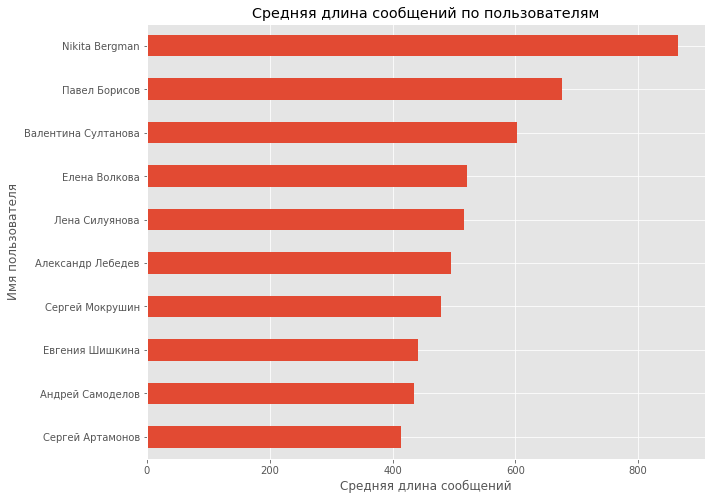

In [27]:
plt.figure(figsize=(10,8))
ax = (
    slack_df.groupby('real_name')['text_length'].mean()
    .nlargest(10).sort_values()
    .plot(kind='barh')
)
plt.title('Средняя длина сообщений по пользователям')
plt.xlabel('Средняя длина сообщений')
plt.ylabel('Имя пользователя')
plt.show()

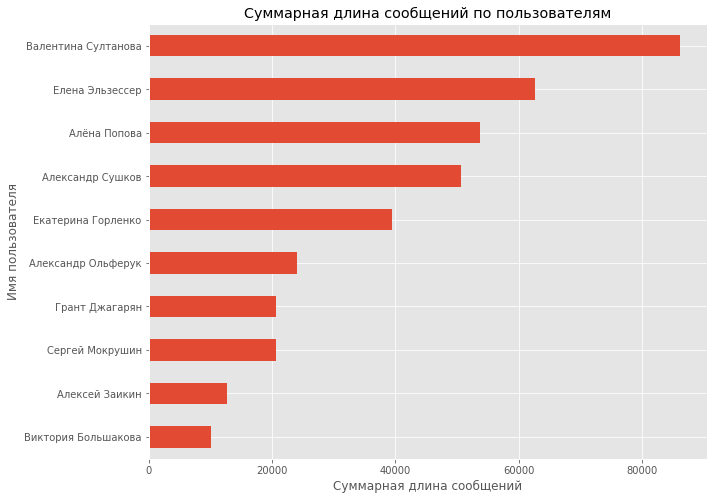

In [28]:
plt.figure(figsize=(10,8))
ax = (
    slack_df.groupby('real_name')['text_length'].sum()
    .nlargest(10).sort_values()
    .plot(kind='barh')
)
plt.title('Суммарная длина сообщений по пользователям')
plt.xlabel('Суммарная длина сообщений')
plt.ylabel('Имя пользователя')
plt.show()